In [23]:
# 라이브러리 불러오기
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

%matplotlib inline

# 코랩 드라이브 연결

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
cd /content/drive/MyDrive/data/project03

/content/drive/MyDrive/data/project03


# 캐글 데이터 다운

In [24]:
# 캐글에서 json 파일 받기
!pip install kaggle
from google.colab import files
files.upload()
# json 파일 업로드

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dongkyuseo","key":"36bb68d379bb6706f952c972bb5f2dff"}'}

In [25]:
# json 파일 업로드 확인
!ls -1ha kaggle.json

kaggle.json


In [26]:
# json 파일 사용을 위한 작업
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json
# 내가 참가한 대회 리스트 확인
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         61           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         83           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        462           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        147           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1454           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      14805           False  
house-pr

# 케글 데이터 api 다운로드

In [27]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.15G/8.16G [01:02<00:00, 142MB/s]
100% 8.16G/8.16G [01:02<00:00, 140MB/s]


## 다운받은 zip 파일 압축 해제

In [28]:
import os
import zipfile

In [29]:
with zipfile.ZipFile(f'flickr-image-dataset.zip', 'r') as existing_zip: # 압축파일 경로 설정
        foldername = 'flickr-image-dataset' # 폴더 이름 추출
        existing_zip.extractall() #압축을 풀어 폴더에 넣기

In [31]:
!pip install --upgrade -q wandb

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 97 kB 5.7 MB/s 
     |████████████████████████████████| 180 kB 63.9 MB/s 
     |████████████████████████████████| 139 kB 68.4 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [71]:
import wandb

import tensorflow as tf
from tensorflow.keras.layers import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import IPython

In [76]:
data_dir = 'flickr30k_images'
image_dir = f'{data_dir}/flickr30k_images'
csv_file = f'{data_dir}/results.csv'

In [77]:
df = pd.read_csv(csv_file, delimiter='|')

print(f'[INFO] The shape of dataframe: {df.shape}')
print(f'[INFO] The columns in the dataframe: {df.columns}')
print(f'[INFO] Unique image names: {len(pd.unique(df["image_name"]))}')

[INFO] The shape of dataframe: (158915, 3)
[INFO] The columns in the dataframe: Index(['image_name', ' comment_number', ' comment'], dtype='object')
[INFO] Unique image names: 31783


In [78]:
df.columns = ['image_name', 'comment_number', 'comment']
del df['comment_number']

# Under scrutiny I had found that 19999 had a messed up entry
df['comment'][19999] = ' A dog runs across the grass .'

# Image names now correspond to the absolute position
df['image_name'] = image_dir+'/'+df['image_name']

# <start> comment <end>
df['comment'] = "<start> "+df['comment']+" <end>"

In [79]:
# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,image_name,comment
0,flickr30k_images/flickr30k_images/3599568766.jpg,<start> A dog runs overtop the dry earth . <end>
1,flickr30k_images/flickr30k_images/8194331212.jpg,<start> A wakeboarder in the ocean is in the ...
2,flickr30k_images/flickr30k_images/2705920066.jpg,<start> two gay guys having fun with a weiner...
3,flickr30k_images/flickr30k_images/4376136908.jpg,<start> A young Indian boy is blowing bubbles...
4,flickr30k_images/flickr30k_images/2204277704.jpg,<start> A boy in a fancy living room jumps fr...


In [80]:
SIZE = len(df)

train_size = int(0.7* SIZE) 
val_size = int(0.1* SIZE)
test_size = int(0.2* SIZE)

train_size, val_size, test_size

(111240, 15891, 31783)

In [81]:
train_df = df.iloc[:train_size,:]
val_df = df.iloc[train_size+1:train_size+val_size,:]
test_df = df.iloc[train_size+val_size+1:,:]

<start>  Three people performing to a crowd outdoors . <end>


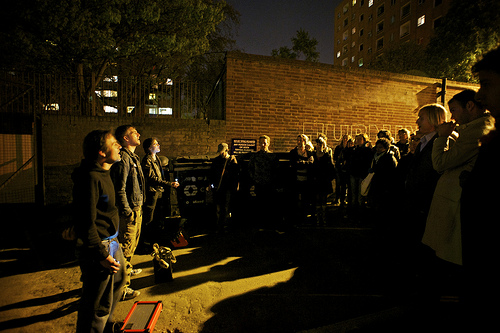

In [91]:
# Enter different indices.
index = 200

image_name = train_df['image_name'][index]
comment = train_df['comment'][index]

print(comment)

IPython.display.Image(filename=image_name)

In [92]:
# Choose the top 5000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')

In [93]:
# build the vocabulary
tokenizer.fit_on_texts(train_df['comment'])

In [94]:
# This is a sanity check function
def check_vocab(word):
    i = tokenizer.word_index[word]
    print(f"The index of the word: {i}")
    print(f"Index {i} is word {tokenizer.index_word[i]}")
    
check_vocab("pajama")

The index of the word: 4768
Index 4768 is word pajama


In [95]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [96]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_df['comment'])
val_seqs = tokenizer.texts_to_sequences(val_df['comment'])
test_seqs = tokenizer.texts_to_sequences(test_df['comment'])

In [97]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
train_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
val_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post')
test_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')

In [98]:
# Caption vector
train_cap_vector.shape, val_cap_vector.shape, test_cap_vector.shape

((111240, 80), (15890, 74), (31783, 65))

In [99]:
train_cap_ds = tf.data.Dataset.from_tensor_slices(train_cap_vector)
val_cap_ds = tf.data.Dataset.from_tensor_slices(val_cap_vector)
test_cap_ds = tf.data.Dataset.from_tensor_slices(test_cap_vector)

In [100]:
@tf.function
def load_img(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (224, 224))
    return img

In [101]:
train_img_name = train_df['image_name'].values
val_img_name = val_df['image_name'].values
test_img_name = test_df['image_name'].values

In [102]:
train_img_ds = tf.data.Dataset.from_tensor_slices(train_img_name).map(load_img)
val_img_ds = tf.data.Dataset.from_tensor_slices(val_img_name).map(load_img)
test_img_ds = tf.data.Dataset.from_tensor_slices(test_img_name).map(load_img)

In [103]:
# prefecth and batch the dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 512

train_ds = tf.data.Dataset.zip((train_img_ds, train_cap_ds)).shuffle(42).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = tf.data.Dataset.zip((val_img_ds, val_cap_ds)).shuffle(42).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds = tf.data.Dataset.zip((test_img_ds, test_cap_ds)).shuffle(42).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [104]:
run = wandb.init(project="show-and-tell",
                 entity="collaborativeml",
                 name="ariG-devJ-img-cap",
                 save_code=False)

images = []
for img, cap in test_ds.take(1):
    batch_size = img.shape[0]
    for i in range(batch_size):
        text = []
        for c in cap[i]:
            if c.numpy() == 0:
                break
            text.append(tokenizer.index_word[c.numpy()])
        images.append(wandb.Image(img[i],
                                  caption=' '.join(text)))
run.log({"img":images})
run.finish()

Problem at: <ipython-input-104-ded48def3e7f> 4 <module>


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 870, in init
    run = wi.init()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 566, in init
    backend.cleanup()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/backend/backend.py", line 228, in cleanup
    self.interface.join()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_queue.py", line 481, in join
    super(InterfaceQueue, self).join()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 591, in join
    self._communicate_shutdown()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_queue.py", line 478, in _communicate_shutdown
    _ = self._communicate(record)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_queue.py", line 232, in _communicate
    return self._communicate_async(rec, local=local).get(timeout=ti

Exception: ignored